In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [2]:
!ls '../../Fed_up/data/preprocessed'

recipe_pp.csv review_pp.csv


In [3]:
reviews = pd.read_csv('../../Fed_up/data/preprocessed/review_pp.csv')

In [4]:
reviews.shape[0]

901746

In [5]:
reviews.head()

,recipe_id,user_id,rating,liked,review,date
0,120345,52282,4,1,very very sweet. after i waited the 2 days i b...,2005-05-21
1,120345,124416,0,0,"Just an observation, so I will not rate. I fo...",2011-08-06
2,120345,2000192946,2,0,This recipe was OVERLY too sweet. I would sta...,2015-05-10
3,134728,76535,4,1,Very good!,2005-09-02
4,134728,273745,5,1,Better than the real!!,2005-12-22


In [6]:
reviews = reviews[reviews['rating'] > 0]

<AxesSubplot:xlabel='rating', ylabel='Count'>

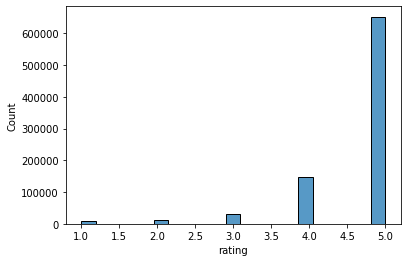

In [7]:
sns.histplot(reviews['rating'])

# Train/Test Split

In [22]:
def generate_test_data(data, min_reviews=2):
    
    # Fetching the review dataframe
    # print("Fetching the review dataframe...")
    # data = pd.read_csv(filepath)
    
    # Creating user / reviews dict
    print("Creating user and reviews dict...")
    user_reviews = data.groupby('user_id') \
                       .agg({'recipe_id': (lambda x: list(x)), 
                             'rating': (lambda x: list(x)),
                             'liked': (lambda x: list(x))}) \
                       .reset_index()
            
    # Selecting only users with at least min_reviews (2 by default)
    print(f"Selecting only users with at least {min_reviews} reviews...")
    selected_user_reviews = user_reviews[user_reviews['recipe_id'].str.len() >= min_reviews]
    
    print("Create and filling evaluation dataframe...")
    
    # Create evaluation dataframe
    test_df = pd.DataFrame(columns=['user_id', 'inputs', 'target', 'rating', 'liked'])
    
    # Filling in the evaluation dataframe
    for index, row in selected_user_reviews.iterrows():
        user = row['user_id']
        target = row['recipe_id'][-1]
        liked = row['liked'][-1]
        rating = row['rating'][-1]
        inputs = {row['recipe_id'][i]: row['liked'][i] for i in range(len(row['recipe_id']) - 1)}

        new_row = {'user_id': user, 'inputs': inputs, 'target': target, 'rating': rating, 'liked': liked}
        test_df = test_df.append(new_row, ignore_index=True)
        
    return test_df

In [23]:
data = generate_test_data(reviews, min_reviews=2)

Creating user and reviews dict...
Selecting only users with at least 2 reviews...
Create and filling evaluation dataframe...


In [24]:
data.head()

,user_id,inputs,target,rating,liked
0,1533,"{116345: 1, 32907: 1, 24136: 1, 35346: 1, 9662...",25844,5,1
1,1535,"{50022: 1, 78834: 1, 47474: 1, 230720: 1, 1411...",116202,5,1
2,1634,"{16512: 1, 158215: 1, 26212: 1, 168194: 0, 114...",22689,5,1
3,1676,"{34233: 1, 99156: 1, 66799: 1, 166273: 1, 2506...",163276,5,1
4,1773,{278: 1},7435,5,1


In [123]:
def generate_rating(df):
    cumdist = data.groupby('rating')['rating'].count().sort_index().cumsum() / len(data)
    bined_rec_score = pd.qcut(data['rec_score'], q=[0.0] + list(cumdist.values))
    new_rating = pd.qcut(data['rec_score'], q=[0.0] + list(cumdist.values), labels=list(cumdist.index)).astype(int)
    return new_rating

In [149]:
from scipy.stats import lognorm

def run_test(data, predict=False):
    
    if predict:
        pass
    else:
        ln = lognorm.rvs(0.2, size=data.shape[0])
        predictions = (ln - ln.min()) / (ln.max() - ln.min())
        
    data['rec_score'] = predictions
    data['rec_rating'] = generate_rating(data[['rating', 'rec_score']])
    data['rec_liked'] = 0
    data['rec_classify'] = ''
    
    for index, row in data.iterrows():
        if data.loc[index, 'rec_rating'] >= 4:
            data.loc[index, 'rec_liked'] = 1
        
        actual = data.loc[index, 'liked'] == 1
        predict = data.loc[index, 'rec_liked'] == 1
        
        if predict and actual:
            data.loc[index, 'rec_classify'] = 'TP'
        elif predict and not actual:
            data.loc[index, 'rec_classify'] = 'FP'
        elif not predict and not actual:
            data.loc[index, 'rec_classify'] = 'TN'
        elif not predict and actual: 
            data.loc[index, 'rec_classify'] = 'FN'
    
    return data

In [150]:
test_data = run_test(data)

In [151]:
test_data.sample(10)

,user_id,inputs,target,rating,liked,rec_score,rec_rating,rec_liked,rec_classify
15391,317096,{51872: 1},159576,5,1,0.198090,4,1,TP
12807,254149,{78772: 1},67117,5,1,0.250782,5,1,TP
5071,103142,"{309043: 1, 74982: 1, 68306: 1, 74810: 1, 4500...",347212,5,1,0.322862,5,1,TP
28163,735318,{69633: 1},69630,5,1,0.173706,4,1,TP
13726,278152,"{54112: 1, 122033: 1, 115222: 1, 121262: 1, 12...",102394,5,1,0.207759,5,1,TP
6612,134583,{77201: 1},291063,5,1,0.213696,5,1,TP
44166,2916010,"{441156: 1, 7020: 0, 324951: 1, 191465: 1, 396...",107317,5,1,0.303971,5,1,TP
44403,45716210,"{754: 1, 70117: 1, 151957: 1}",370354,5,1,0.367033,5,1,TP
41276,1818165,{169050: 1},230902,5,1,0.443860,5,1,TP
43322,2482292,{194664: 1},204071,5,1,0.202600,4,1,TP


In [144]:
test_data.rating.value_counts()

5    36418
4     7355
3     1924
2      872
1      806
Name: rating, dtype: int64

In [145]:
test_data.rec_rating.value_counts()

5    36418
4     7355
3     1924
2      872
1      806
Name: rec_rating, dtype: int64

# Rating

## MAE

In [153]:
def rating_mae(data):
    mae = np.mean(np.abs(data['rating'] - data['rec_rating']))
    return np.round(mae, 3)

## Large Error %

In [156]:
def rating_le(data, dif_threshold=1):
    le = [1 if (data.loc[index, 'rating'] - data.loc[index, 'rec_rating']) > dif_threshold else 0 for index, row in data.iterrows()]
    return np.round(sum(le) / len(le), 3)

# Like Classification

## Like Accuracy

In [133]:
def like_accuracy(data):
    counts = data['rec_classify'].value_counts()
    num = counts.get('TP', 0) + counts.get('TN', 0)
    den = counts.sum()
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

## Like Precision

In [134]:
def like_precision(data):
    counts = data['rec_classify'].value_counts()
    num = counts.get('TP', 0)
    den = counts.get('TP', 0) + counts.get('FP', 0)
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

## Like Recall

In [135]:
def like_recall(data):
    counts = data['rec_classify'].value_counts()
    num = counts.get('TP', 0)
    den = counts.get('TP', 0) + counts.get('FN', 0)
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

## Like F1

In [136]:
def like_f1(data):
    counts = data['rec_classify'].value_counts()
    num = 2 * counts.get('TP', 0)
    den = 2 * counts.get('TP', 0) + counts.get('FN', 0) + counts.get('FP', 0)
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

# Get Scoring Metrics

In [137]:
def get_scoring_metrics(data, sample=None, le_dif_threshold=0.25):
    
    if sample is None:
        tdata = data.copy()
    else:
        tdata = data.copy().sample(sample)
        
    return {'rating_mae': rating_mae(tdata),
            'rating_le': rating_le(tdata, dif_threshold=le_dif_threshold),
            'like_accuracy': like_accuracy(tdata),
            'like_precision': like_precision(tdata),
            'like_recall': like_recall(tdata),
            'like_f1': like_f1(tdata)}

In [157]:
get_scoring_metrics(test_data)

{'rating_mae': 0.596,
 'rating_le': 0.19,
 'like_accuracy': 0.859,
 'like_precision': 0.924,
 'like_recall': 0.924,
 'like_f1': 0.924}

In [139]:
data

,user_id,inputs,target,rating,liked,rec_score,rec_rating,rec_liked,rec_classify
0,1533,"{116345: 1, 32907: 1, 24136: 1, 35346: 1, 9662...",25844,5,1,0.424122,5,1,FN
1,1535,"{50022: 1, 78834: 1, 47474: 1, 230720: 1, 1411...",116202,5,1,0.375867,5,1,FN
2,1634,"{16512: 1, 158215: 1, 26212: 1, 168194: 0, 114...",22689,5,1,0.201213,4,1,FN
3,1676,"{34233: 1, 99156: 1, 66799: 1, 166273: 1, 2506...",163276,5,1,0.263398,5,1,FN
4,1773,{278: 1},7435,5,1,0.308414,5,1,FN
...,...,...,...,...,...,...,...,...,...
47370,2002331093,{388066: 0},79388,5,1,0.574873,5,1,FN
47371,2002346480,{332323: 0},407995,5,1,0.203107,4,1,FN
47372,2002357452,{535852: 1},535853,1,0,0.329560,5,1,TN
47373,2002357459,{535852: 1},535853,5,1,0.421892,5,1,FN


In [86]:
cumdist = (data.groupby('rating')['rating']
               .count()
               .sort_index()
               .cumsum() 
           / len(data))

In [117]:
new_rating = pd.qcut(data['rec_score'], q=[0.0] + list(cumdist.values), labels=list(cumdist.index)).astype(int)

In [162]:
!ls '../../Fed_up/data/test'

test_inputs.csv
